In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm

from moral_foundations_llms.analysis import cochran_armitage_trend_test
from moral_foundations_llms import keys
from mpl_lego.labels import apply_subplot_labels

from functools import partial
from mpl_lego.labels import bold_text
from scipy.stats import bootstrap
from pyprojroot import here
 
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 0)

In [3]:
mplego.style.use_latex_style()

In [4]:
# df = pd.read_csv(here('data/aita_final_v19.csv'))
df = pd.read_csv(here('data/aita_final_v26.csv')

/var/folders/6h/ms_dpkl536d1w6qqd_wnckrw0000gn/T/ipykernel_12053/3910640470.py:1: DtypeWarning: Columns (29,34,35,189,190) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(here('data/aita_final_v19.csv'))


In [10]:
n_moral_themes = 6

In [5]:
all_probs = [[f'{reason}_{moral}_prob'
              for moral in keys.MORAL_AXES]
             for reason in keys.REASON_COLS]

In [6]:
for (model, label_col), probs in zip(keys.models_to_labels.items(), all_probs):
    df[f'{model}_n_themes'] = (df[probs] > 0.5).sum(axis=1)

In [7]:
def YTA_vs_n_themes(df, model):
    LABEL_COL = keys.models_to_labels[model]
    return df.groupby(f'{model}_n_themes').apply(
        lambda x: (x[LABEL_COL] == 'YTA').mean()
    ).reset_index(name=f'{model}_YTA_fraction', drop=True)

In [8]:
def YTA_vs_n_themes_bootstrap(records, model, n_themes):
    LABEL_COL = keys.models_to_labels[model]
    labels = records[LABEL_COL]
    sub = labels[records[f'{model}_n_themes'] == n_themes]
    if sub.size == 0:
        return 0
    return (sub == 'YTA').mean()

In [9]:
means = [YTA_vs_n_themes(df, model) for model in keys.MODELS]

In [12]:
bootstraps = [[bootstrap((df[[keys.models_to_labels[model], f'{model}_n_themes']].to_records(index=False),),
                        partial(YTA_vs_n_themes_bootstrap, model=model, n_themes=idx))
              for idx in range(n_moral_themes)]
              for model in keys.MODELS]

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the stati

In [13]:
for model in keys.MODELS:
    contingency_table = np.array([
        df.groupby(f'{model}_n_themes').apply(
            lambda x: (x[keys.models_to_labels[model]] == 'YTA').sum()
        ).reset_index(name=f'{model}_YTA_fraction', drop=True).values,
        df.groupby(f'{model}_n_themes').apply(
            lambda x: (x[keys.models_to_labels[model]] != 'YTA').sum()
        ).reset_index(name=f'{model}_YTA_fraction', drop=True).values]).T[1:-1]

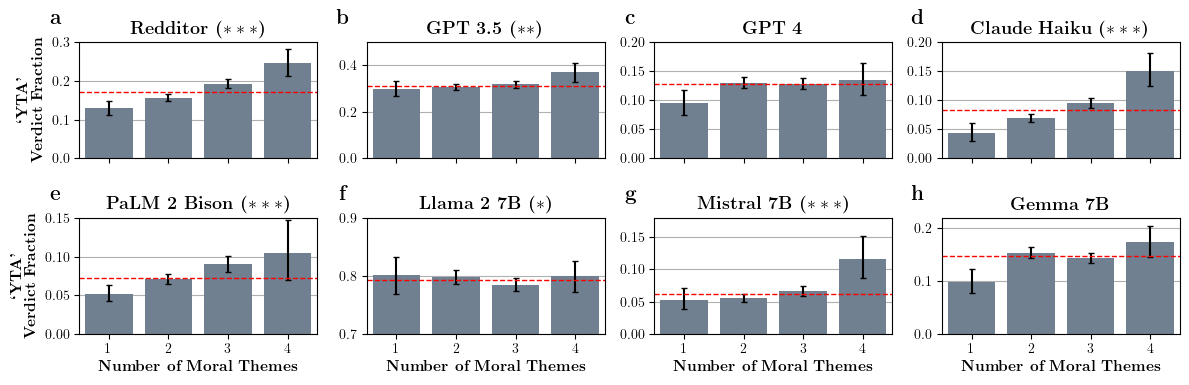

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=True)
sigs = [r' ($\ast \ast \ast$)', r' ($\ast \ast$)', '', r' ($\ast \ast \ast$)', r' ($\ast \ast \ast$)', r' ($\ast$)', r' ($\ast \ast \ast$)', '']

for idx, (ax, vals, mean, sig) in enumerate(zip(axes.ravel(), bootstraps, means, sigs)):
    
    uppers = [bootstrap.confidence_interval.high for bootstrap in vals]
    lowers = [bootstrap.confidence_interval.low for bootstrap in vals]

    ax.bar(np.arange(6),
           mean.values,
           color='slategray',
           yerr=[[mean - lower for lower, mean in zip(lowers, mean.values)],
                 [upper - mean for upper, mean in zip(uppers, mean.values)]],
           capsize=2)

    ax.axhline((df[keys.LABEL_COLS[idx]] == 'YTA').mean(), color='red', linestyle='--', lw=1)
    ax.set_title(bold_text(keys.MODEL_LABELS_PLOT[idx] + sig), fontsize=13)
    ax.set_xticks(np.arange(6))

    ax.set_xlim([0.5, 4.5])
    ax.grid(axis='y')
    
    ax.set_axisbelow(True)

axes[0, 0].set_ylim(top=0.3)
axes[0, 1].set_ylim(top=0.5)
axes[0, 2].set_ylim(top=0.2)
axes[0, 3].set_ylim(top=0.2)
axes[1, 0].set_ylim(top=0.15)
axes[1, 1].set_ylim(top=0.9, bottom=0.7)
axes[1, 2].set_ylim(top=0.18)
axes[1, 3].set_ylim(top=0.22)

for ax in axes[1]:
    ax.set_xlabel(bold_text('Number of Moral Themes'), fontsize=11)

for ax in axes[:, 0]:
    ax.set_ylabel(bold_text("`YTA'\nVerdict Fraction"), fontsize=11)
    
apply_subplot_labels(axes, bold=True, x=-0.10, y=1.2)

plt.tight_layout()
plt.savefig('yta_vs_reasons.pdf', bbox_inches='tight')